In [2]:
%load_ext cython

In [3]:
import itertools
import MDAnalysis as mda
import MDAnalysis.analysis.base
from MDAnalysis.analysis import distances
import numpy as np


class DistanceAnalysis(MDAnalysis.analysis.base.AnalysisBase):
    def __init__(self, ag1, ag2, **kwargs):
        super(DistanceAnalysis, self).__init__(
            ag1.universe.trajectory, **kwargs)
        self._ag1 = ag1
        self._ag2 = ag2

    def _prepare(self):
        self.result = []

    def _single_frame(self):
        self.result.append(distances.dist(self._ag1, self._ag2)[-1])

    def _conclude(self):
        self.result = np.array(self.result)


class COM_analysis(MDAnalysis.analysis.base.AnalysisBase):
    def __init__(self, ag, **kwargs):
        super(COM_analysis, self).__init__(ag.universe.trajectory, **kwargs)
        self._ag = ag

    def _prepare(self):
        self.result = []

    def _single_frame(self):
        self.result.append(self._ag.center_of_mass())

    def _conclude(self):
        self.result = np.array(self.result)


def dis(vector):
    dis = []
    for i, vec in enumerate(vector):
        dis.append(np.linalg.norm(vec))
    dis = np.array(dis)
    return dis


def chunked_iterable(iterable, size):
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, size))
        if not chunk:
            break
        yield chunk


def distance_Phe_His(pdb, traj):  # info = [pdb, traj, ]
    sim = mda.Universe(pdb, traj)

    # Select atoms
    His_ring = sim.select_atoms(
        'resid 163 and not backbone and not name CB and not name H*')
    Phe_ring = sim.select_atoms(
        'resid 140 and not backbone and not name CB and name C*')
    # Calculation
    COM_Phe = []
    for n in range(2):
        com2 = COM_analysis(Phe_ring[int(n*6):int(n*6+6)])
        com2.run()
        COM_Phe.append(com2.result[:])
    COM_Phe = np.array(COM_Phe)
    COM_His = []
    for n in range(2):
        com3 = COM_analysis(His_ring[int(n*5):int(n*5+5)])
        com3.run()
        COM_His.append(com3.result[:])
    COM_His = np.array(COM_His)
    vec_Phe_His_A = COM_Phe[0] - COM_His[0]
    vec_Phe_His_B = COM_Phe[1] - COM_His[1]
    dist = np.array([dis(vec_Phe_His_A)]+[dis(vec_Phe_His_B)])
    dist = dist.T
    return dist

In [3]:
%%cython

cdef int a = 0
cdef int i = 0

for i in range(10):
    a += 1
print(a)

In [5]:
%%cython --annotate

cdef int a = 0
# cdef int i = 0

for i in range(10):
    a += 1
print(a)

10


In [4]:
%%cython

import numpy as np
cimport numpy as np

cdef extern from "math.h":
    double sqrt(double)

def cdistance(np.ndarray[np.float64_t, ndim=1] x, np.ndarray[np.float64_t, ndim=1] y):
    cdef int i, lmax
    cdef double d, tmp
    lmax = x.shape[0]
    d = 0.
    for i in range(lmax):
        tmp = x[i] - y[i]
        d += tmp*tmp
    return sqrt(d)

def c_calc_min_dist(np.ndarray[np.float64_t, ndim=3] crd_a,
                    np.ndarray[np.float64_t, ndim=3] crd_b,
                    list a_names,
                    list b_names):
    cdef:
        int a_max = crd_a.shape[1]
        int b_max = crd_b.shape[1]
        int i, j = 0
        double dist = 0.
        np.ndarray[np.float64_t, ndim=1] dist_a = np.zeros([a_max], dtype=float)
        np.ndarray[np.float64_t, ndim=1] dist_b = np.zeros([b_max], dtype=float)
        double[:,:,:] crd_a_view = crd_a
        double[:,:,:] crd_b_view = crd_b
        double[:] dist_a_view = dist_a
        double[:] dist_b_view = dist_b
    
    dist_a.fill(99.)
    dist_b.fill(99.)
    
    for i in range(a_max):
        if a_names[i] != 'hydrogen':
            for j in range(b_max):
                if b_names[j] != 'hydrogen':
                    dist = cdistance(crd_a[0,i,:], crd_b[0,j,:])
                    if dist < dist_a_view[j]:
                        dist_a_view[i] = dist
                    if dist < dist_b_view[j]:
                        dist_b_view[j] = dist
    
    return dist_a, dist_b
                

In [60]:
import mdtraj as md
ref = md.load('selected_frs_TS0_1_black.pdb')

a = ref.topology.select("chainid 0")
b = ref.topology.select("chainid 1")
top_a = ref.topology.subset(a)
top_b = ref.topology.subset(b)
traj_a = md.Trajectory(ref.xyz[0,0:4682,:], top_a)
traj_b = md.Trajectory(ref.xyz[0,4682::,:], top_b)
traj_a.superpose(ref,frame=0,atom_indices=a,ref_atom_indices=b)
traj_b.superpose(ref,frame=0,atom_indices=a,ref_atom_indices=a)
xyz = np.concatenate((traj_a.xyz,traj_b.xyz), axis=1)
print(xyz.shape, xyz)
pdb = md.Trajectory(xyz, ref.topology)



(1, 9364, 3) [[[6.7229857 6.5426073 2.4981084]
  [6.6362267 6.507355  2.4593244]
  [6.704744  6.6237993 2.554251 ]
  ...
  [6.042998  7.6989694 4.834039 ]
  [6.1339974 7.772971  4.8790364]
  [5.958996  7.7389674 4.75104  ]]]


In [24]:
c_calc_min_dist(traj_a.xyz.astype(np.float64), traj_b.xyz.astype(np.float64))

(array([0.13896516, 0.14694298, 0.1431823 , ..., 0.21869405, 0.13897533,
        0.20753086]),
 array([0.26156263, 0.27166994, 0.31752157, ..., 0.29106402, 0.26352651,
        0.38894283]))

In [5]:
import glob
files = glob.glob('cluster_center_results/*.pdb')
files.sort()

In [178]:
def get_min_dist(file):
    ref = md.load(file)
    names = []
    for i in range(ref.n_atoms):
        atom = list(ref.topology.atoms)[i]
        names.append(atom.element.name)
    dist_a, dist_b = c_calc_min_dist(ref.xyz[:,0:4682,:].astype(np.float64), ref.xyz[:,4682::,:].astype(np.float64), names[0:4682], names[4682::])
    bfactor = np.concatenate((dist_a, dist_b))
    ref.save_pdb(f'results/bfactor_dists/bfactor_noH_longcutoff_{file[8:]}', bfactors=bfactor)
    a = ref.topology.select("index 0 to 4681")
    b = ref.topology.select("index 4682 to 9364")
    top_a = ref.topology.subset(a)
    top_b = ref.topology.subset(b)
    traj_a = md.Trajectory(ref.xyz[0,0:4682,:], top_a)
    traj_b = md.Trajectory(ref.xyz[0,4682::,:], top_b)
    # traj_a.save_pdb(f'results/bfactor_dists/bfactor_{file[8:]}_{files[0][8:][-6:-4]}', bfactors=bfactor)
    print(f'bfactor_{file[8:]}:')
    count = 0
    for i,atom in enumerate(ref.topology.atoms):
        if bfactor[i]<0.1:
            if atom.element.name != 'hydrogen':
                count += 1
    return count
    

In [179]:
import mdtraj as md
data = np.zeros((len(files), 3))
for i,file in enumerate(files):
    num_clashes = get_min_dist(file)
    dist_140_163 = distance_Phe_His(file, file)
    data[i][0] = dist_140_163[0][0]
    data[i][1] = dist_140_163[0][1]
    data[i][2] = num_clashes
np.save('results/bfactor_dists/bfactor_noH_center_results/numpy/plotdata_longcuttoff.npy', data)

bfactor_center_results/0000_AA.pdb:


/home/jim/anaconda3/envs/FFTp39/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:431: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/home/jim/anaconda3/envs/FFTp39/lib/python3.9/site-packages/MDAnalysis/coordinates/base.py:903: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


bfactor_center_results/0000_BA.pdb:
bfactor_center_results/0000_BB.pdb:
bfactor_center_results/0001_AA.pdb:
bfactor_center_results/0001_BA.pdb:
bfactor_center_results/0001_BB.pdb:
bfactor_center_results/0002_AA.pdb:
bfactor_center_results/0002_BA.pdb:
bfactor_center_results/0002_BB.pdb:
bfactor_center_results/0003_AA.pdb:
bfactor_center_results/0003_BA.pdb:
bfactor_center_results/0003_BB.pdb:
bfactor_center_results/0004_AA.pdb:
bfactor_center_results/0004_BA.pdb:
bfactor_center_results/0004_BB.pdb:
bfactor_center_results/0005_AA.pdb:
bfactor_center_results/0005_BA.pdb:
bfactor_center_results/0005_BB.pdb:
bfactor_center_results/0006_AA.pdb:
bfactor_center_results/0006_BA.pdb:
bfactor_center_results/0006_BB.pdb:
bfactor_center_results/0007_AA.pdb:
bfactor_center_results/0007_BA.pdb:
bfactor_center_results/0007_BB.pdb:
bfactor_center_results/0008_AA.pdb:
bfactor_center_results/0008_BA.pdb:
bfactor_center_results/0008_BB.pdb:
bfactor_center_results/0009_AA.pdb:
bfactor_center_results/0009_

KeyboardInterrupt: 

In [25]:
for i,atom in enumerate(ref.topology.atoms):
    if bfactor[i]<0.06:
        print(atom, bfactor[i])

SER1-CB 0.048661332979897956
ARG4-HE 0.05374881719870599
LYS137-O 0.0537487786770347
GLY170-C 0.04872670498822485
SER1-CB 0.04872670498822485
ARG4-HE 0.0537487786770347
LYS137-O 0.05374881719870599
GLY170-C 0.048661332979897956


In [52]:
names = []
for i in range(ref.n_atoms):
    atom = list(ref.topology.atoms)[i]
    names.append(atom.element.name)

In [23]:
distance_Phe_His(files[0], files[:2000])

array([[4.12209106, 4.12210721],
       [4.12210721, 4.28726709],
       [4.28755496, 4.28726709],
       ...,
       [4.42985542, 4.430108  ],
       [4.73000311, 4.72997118],
       [4.72997118, 4.06861798]])

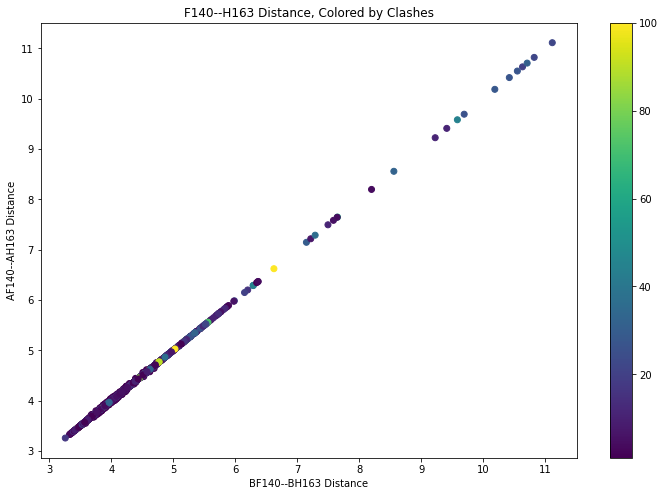

In [100]:
import matplotlib.pyplot as plt

# Create a figure with a specific size
fig = plt.figure(figsize=(12, 8))

# Create the scatter plot with the data
a = data2[2]/data2[2].max()
plt.scatter(data2[0][mask], data2[1][mask], c=data2[2][mask])
plt.clim(1, 100)

# Set the title and axis labels
plt.title('F140--H163 Distance, Colored by Clashes')
plt.xlabel('BF140--BH163 Distance')
plt.ylabel('AF140--AH163 Distance')

# Add a colorbar
plt.colorbar()

# Display the plot
plt.show()

In [97]:
# mask = data2[0] == data2[1]
tolerance = 0.01
mask = np.isclose(data2[0], data2[1], rtol=tolerance, atol=tolerance)
x = data2[0][mask]
y = data2[1][mask]
c = data2[2][mask]

In [52]:
data2 = data.T

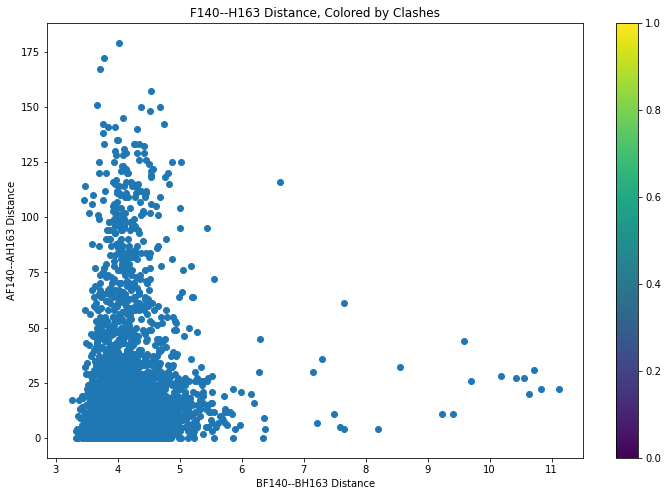

In [98]:
import matplotlib.pyplot as plt

# Create a figure with a specific size
fig = plt.figure(figsize=(12, 8))

# Create the scatter plot with the data
plt.scatter(x, c)
# plt.clim(1, 5)

# Set the title and axis labels
plt.title('F140--H163 Distance, Colored by Clashes')
plt.xlabel('BF140--BH163 Distance')
plt.ylabel('AF140--AH163 Distance')

# Add a colorbar
plt.colorbar()

# Display the plot
plt.show()

In [1]:
import numpy as np
data = np.load('/home/jim/Desktop/ella_paper/Mpro_paper_working/jim_vmd/figure_s_clash/results/bfactor_dists/bfactor_noH_center_results/numpy/plotdata.npy')
x1 = data[::3,0]
x2 = data[2::3,0]
y1 = data[::3,2]
y2 = data[2::3,2]
c1 = np.full(x1.shape, 1)
c2 = np.full(x2.shape, 0)
z = data[2::3,2]

In [2]:
x = np.column_stack((x1, x2)).reshape((-1,), order='F')
y = np.column_stack((y1, y2)).reshape((-1,), order='F')
c = np.column_stack((c1, c2)).reshape((-1,), order='F')

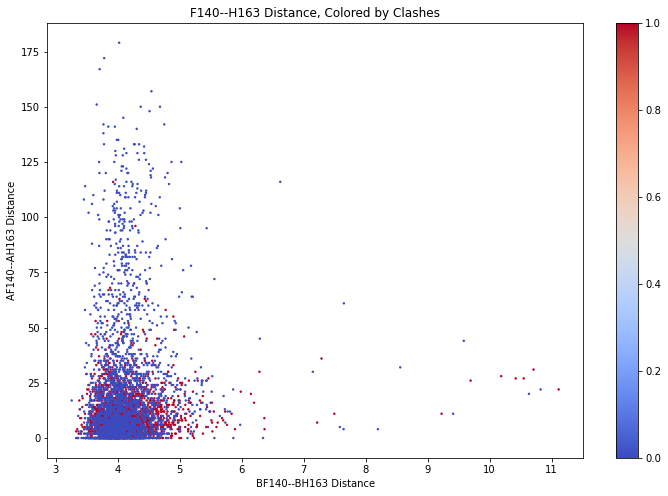

In [135]:
import matplotlib.pyplot as plt

# Create a figure with a specific size
fig = plt.figure(figsize=(12, 8))

# Create the scatter plot with the data
plt.scatter(x, y, 2, c, cmap='coolwarm')
# plt.clim(1, 5)

# Set the title and axis labels
plt.title('F140--H163 Distance, Colored by Clashes')
plt.xlabel('BF140--BH163 Distance')
plt.ylabel('AF140--AH163 Distance')

# Add a colorbar
plt.colorbar()

# Display the plot
plt.show()

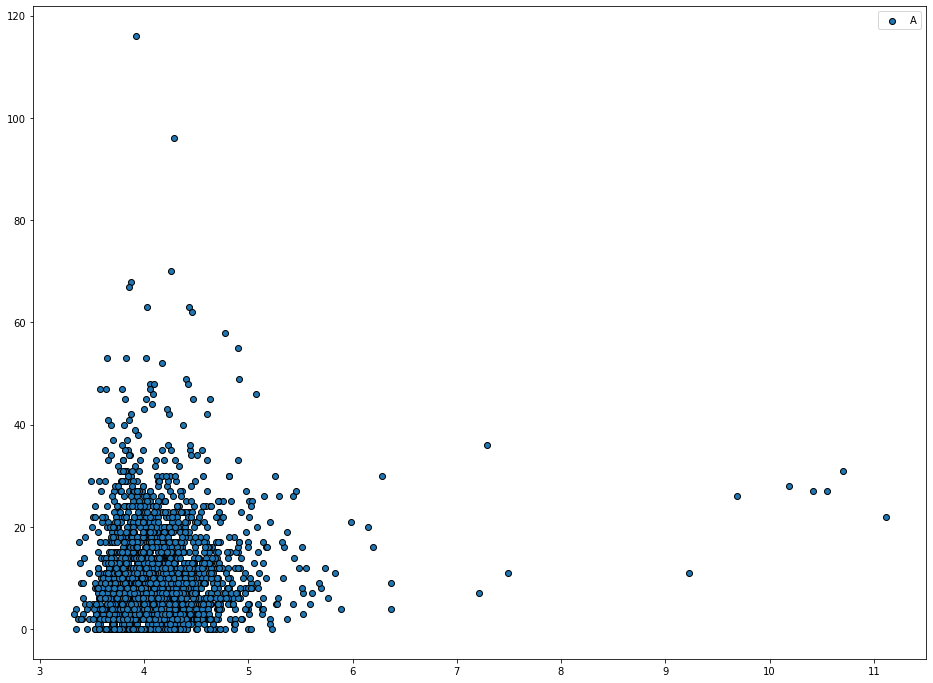

In [168]:
fig = plt.figure(figsize=(16, 12))

# Create a scatter plot with two colors
# plt.scatter(x1, y1, c='red', label='A', edgecolor="black")
# plt.scatter(x2, y2, c='green', label='B', edgecolor="black")

plt.scatter(x1, y1, facecolor="tab:blue", label='A', edgecolor="black")
# plt.scatter(x2, y2, s=20, alpha=0.5, facecolor="tab:orange", label='B', edgecolor="black")

# Add a legend
plt.legend()

# Show the plot
plt.show()

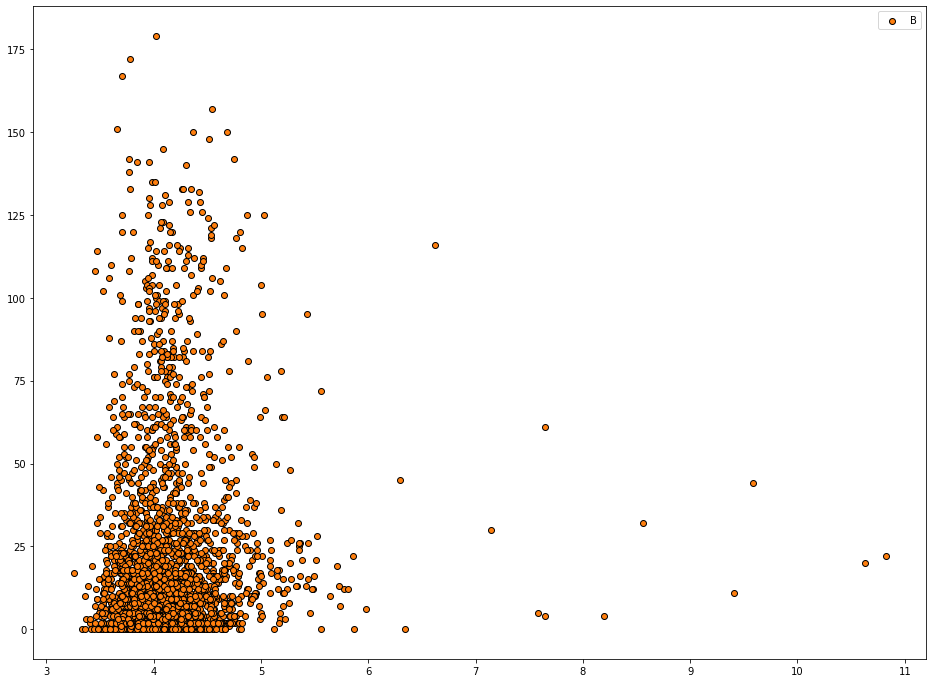

In [169]:
fig = plt.figure(figsize=(16, 12))

# Create a scatter plot with two colors
# plt.scatter(x1, y1, c='red', label='A', edgecolor="black")
# plt.scatter(x2, y2, c='green', label='B', edgecolor="black")

plt.scatter(x2, y2, facecolor="tab:orange", label='B', edgecolor="black")
# plt.scatter(x2, y2, s=20, alpha=0.5, facecolor="tab:orange", label='B', edgecolor="black")

# Add a legend
plt.legend()

# Show the plot
plt.show()

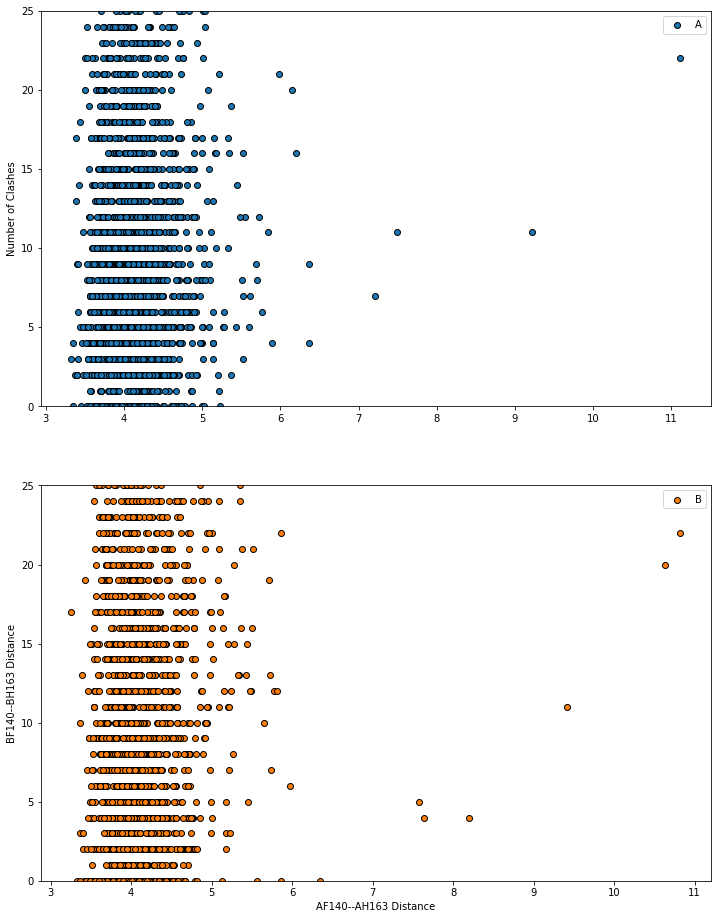

In [8]:
import matplotlib.pyplot as plt
# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 16))

# Create the top scatter plot
axs[0].scatter(x1, y1, facecolor="tab:blue", label='A', edgecolor="black")
axs[0].set_ylim([0,25])
# Create the bottom scatter plot
axs[1].scatter(x2, y2, facecolor="tab:orange", label='B', edgecolor="black")
axs[1].set_ylim([0,25])
# Add legends to both plots
axs[0].legend()
axs[1].legend()

# Add axis labels to both plots
axs[0].set_ylabel('Number of Clashes')
axs[1].set_xlabel('AF140--AH163 Distance')
axs[1].set_ylabel('BF140--BH163 Distance')

# Show the plot
plt.show()

In [188]:
import mdtraj as md
indices = np.random.choice(files, size=50)
data = np.zeros((len(indices), 3))
for i,file in enumerate(files):
    num_clashes = get_min_dist(file)
    dist_140_163 = distance_Phe_His(file, file)
    data[i][0] = dist_140_163[0][0]
    data[i][1] = dist_140_163[0][1]
    data[i][2] = num_clashes
np.save('results/bfactor_dists/bfactor_noH_center_results/numpy/plotdata_longcuttoff.npy', data)

END


/home/jim/anaconda3/envs/FFTp39/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


bfactor_center_results/0000_AA.pdb:


/home/jim/anaconda3/envs/FFTp39/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:431: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/home/jim/anaconda3/envs/FFTp39/lib/python3.9/site-packages/MDAnalysis/coordinates/base.py:903: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


bfactor_center_results/0000_BA.pdb:
bfactor_center_results/0000_BB.pdb:
bfactor_center_results/0001_AA.pdb:
bfactor_center_results/0001_BA.pdb:
bfactor_center_results/0001_BB.pdb:
bfactor_center_results/0002_AA.pdb:
bfactor_center_results/0002_BA.pdb:
bfactor_center_results/0002_BB.pdb:
bfactor_center_results/0003_AA.pdb:
bfactor_center_results/0003_BA.pdb:
bfactor_center_results/0003_BB.pdb:
bfactor_center_results/0004_AA.pdb:
bfactor_center_results/0004_BA.pdb:
bfactor_center_results/0004_BB.pdb:
bfactor_center_results/0005_AA.pdb:
bfactor_center_results/0005_BA.pdb:
bfactor_center_results/0005_BB.pdb:
bfactor_center_results/0006_AA.pdb:
bfactor_center_results/0006_BA.pdb:
bfactor_center_results/0006_BB.pdb:
bfactor_center_results/0007_AA.pdb:
bfactor_center_results/0007_BA.pdb:
bfactor_center_results/0007_BB.pdb:
bfactor_center_results/0008_AA.pdb:
bfactor_center_results/0008_BA.pdb:
bfactor_center_results/0008_BB.pdb:
bfactor_center_results/0009_AA.pdb:
bfactor_center_results/0009_

KeyboardInterrupt: 